### Exponential Random Graph Model

#### Import libraries:

In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy
import numpy as np
from numpy.linalg import inv
from numpy.linalg import pinv
from scipy.special import comb

#### Set initial guesses and parameters

In [113]:
alpha = -0.849 # 1.6
gamma = -0.51 # -1.5 1 #newly specified parameter
stop_threshold = 0.01
n = int(12)
p = float(0.15)
Q = 2200
q = 200
Tao = 10
nchoose3 = comb(n,3,exact=True)
m_list=[]
t_list=[]

#### Create an initial graph, either randomly or as an input:

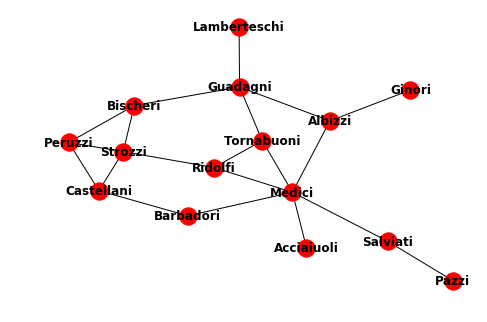

In [132]:
#def create_graph(n,p):
#    try:
#        G.clear()
#    except:
#        pass
#    G = nx.Graph()
#    for q in range(n):
#        G.add_node(q)
#    for i in range(n):
#        for j in range(i+1,n):
#            if random.random()<p:
#                G.add_edge(i,j)
#    return(G)

#def create_graph(n,p):
#    G=nx.Graph()
#    G.add_edges_from([(1,2),(1,12),(3,4),(3,7),(3,8),\
#             (3,12),(4,5),(4,11),(4,12),(5,6),\
#             (5,10),(6,7),(7,10),(8,10),(8,11),\
#             (9,10),(10,11),(11,12)])
#    return(G)


def create_graph(n,p):
    G_fl = nx.florentine_families_graph()
    G2=nx.convert_node_labels_to_integers(G_fl)
    return(G_fl)

G = create_graph(n,p)
nx.draw(G,with_labels=True,font_weight='bold')

G_naught_m = len(G.edges()) # stopping parameter

#### Counting triangles using a NetworkX function that returns the sum of all triangle counts by node, then dividing by 3:

In [127]:
def tri_count(G):
    t_count=0
    for k,v in nx.triangles(G).items():
        t_count+=v
    t_count=t_count/3
    return(t_count)

G_naught_t = tri_count(G) # stopping parameter

print(G_naught_t)
#print(PGprime_PG(200,198,5,6,.4,.8)) # Test calculation

3.0


#### Calculate the probability of $P_{G'}$ relative to $P_G$ using the following equation:
$$\frac{P_{G'}}{P_{G}} = e^{\alpha (m'-m) + \gamma (t' -t)}$$

In [128]:
def PGprime_PG(m,mp,t,tp,alpha,gamma): 
    #links, links prime, triangles, triangles prime, alpha and gamma parameters
    # e ^( (alpha * (m(G')-m(G))) + (gamma * (t(G')-t(G))))
    PGp_PG = math.exp((alpha*(mp-m)+gamma*(tp-t)))
    return(PGp_PG)

temp_m = G.number_of_edges()
temp_mp = temp_m+1
temp_t = tri_count(G)
temp_tp = temp_t+1
PGp_PG = PGprime_PG(temp_m,temp_mp,temp_t,temp_tp,alpha,gamma)
print(PGp_PG)

0.25691756610368544


#### The metropolis step identifies a node at random, then identifies a second node at random that does not equal the first selected node. If there is an edge between them, it is deleted, and if there is not an edge between them, one is added.

#### Alternatively, the binary status of the edge is set to |$a_{ij}$-1| where $a_{ij}$ was the prior state.

In [129]:
def metropolis_step(G,alpha,gamma):
    Gp = deepcopy(G)
    i = random.randint(1,len(Gp.nodes)-1)
    j = random.randint(1,len(Gp.nodes)-2)
    if j==i or j>i:
        j+=1
    if j in Gp.neighbors(i):
        Gp.remove_edge(i,j)
    else: Gp.add_edge(i,j)
    """
    # for proofing, uncomment the following to compare the selected nodes
    # and the link lists of G and G' 
    print(i,j)
    print(G.edges())
    print(Gp.edges())
    """
    t,tp = tri_count(G),tri_count(Gp)
    m,mp = G.number_of_edges(),Gp.number_of_edges()
    PGp_PG = PGprime_PG(m,mp,t,tp,alpha,gamma)
    if PGp_PG >= 1:
        #print('Gp')
        return(Gp)
    else:
        accept_proba = random.random()
        if PGp_PG > accept_proba:
            #print('Gp')
            return(Gp)
        else: 
            #print('G')
            return(G)

G = create_graph(n,p)
G_update = metropolis_step(G,alpha,gamma)
plt.figure(1)
nx.draw(G,with_labels=True,font_weight='bold')
plt.figure(2)
nx.draw(G_update,with_labels=True,font_weight='bold')

NetworkXError: The node 2 is not in the graph.

#### The Markov Chain Monte Carlo simulation iteratively uses Metropolis steps to simulate the given parameters for graphs. 

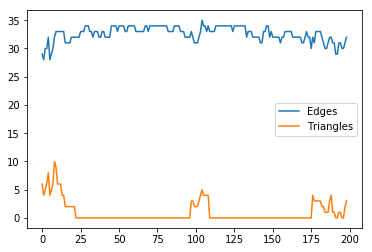

average edges 32.60301507537689
average triangles 0.9296482412060302


In [59]:
def MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma): #change this function to run burn in, then to only update counter as noted below
    G=create_graph(n,p)
    initial_tri = tri_count(G)
    initial_edges = G.number_of_edges()
    count=0
    tri=0
    edge=0
    for a in range(Q): # Change this line to only update the count for cases where a new graph is accepted
        G=metropolis_step(G,alpha,gamma)
        if a > q:
            if a%Tao==0:
                links = G.number_of_edges()
                m_list.append(links)
                triangles = tri_count(G)
                t_list.append(triangles)
                count+=1
                tri+=tri_count(G)
                edge+=G.number_of_edges()
    avg_m = edge/count
    avg_t = tri/count
    return(m_list,t_list,avg_m,avg_t,initial_tri,initial_edges)


m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
plt.plot(m_list,label="Edges")
plt.plot(t_list,label="Triangles")
plt.legend()
plt.show()
print('average edges',avg_m)
print('average triangles',avg_t)

#### The following functions are simple statistical functions needed to calculate a Newton step for the MCMC. 

Average: 
$$\frac{\sum\limits_{i=1}^n x_{i}}{n} $$

Variance:
$$\frac{\sum\limits_{i=1}^n (x_{i}- \bar{x})}{n}$$

Covariance:
$$\frac{\sum\limits_{i=1}^n (x_{i}- \bar{x})(y_{i}- \bar{y})}{n}$$


In [26]:
def average(list_):
    temp=0
    for i in list_:
        temp+=i
    temp=temp/len(list_)
    return(temp)

In [27]:
def variance(list_):
    aver = average(list_)
    var = 0
    #temp_val = 0
    for i in list_:
        temp_val = (i-aver)**2
        var += temp_val
    var=var/len(list_)
    return(var,aver)

In [28]:
def covariance(list1,list2,m_ave,t_ave):
    aver_prod = m_ave*t_ave
    combined = zip(list1,list2)
    temp_list = []
    for i in combined:
        temp_list.append(i[0]*i[1])
    aver_temp = average(temp_list)
    covar = aver_temp-aver_prod
    return(covar)

#### The final component is the Exponential Random Graph Model. This takes the prior input graph and parameters, then iterates through alpha and gamma using the Newton Raphson method until the change in these is less than some specified threshold. At this point, it prints the results of the process.

In [114]:
def ERGM(alpha,gamma,stop_threshold):
    
    stop = 0
    counter =0
    old_alpha =alpha
    old_gamma =gamma
    while stop < 1:
        m_list,t_list =[],[]
        counter+=1
        m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
        old_m_ave,old_t_ave= initial_edges,initial_tri
        m_var,m_ave = variance(m_list)
        t_var,t_ave = variance(t_list)
        covar = covariance(m_list,t_list,m_ave,t_ave)
        D = np.matrix([[m_var,covar],[covar,t_var]])
        Dinv = inv(D)
        mt_array = np.array([m_ave-old_m_ave,t_ave-old_t_ave])
        step = np.dot(Dinv,mt_array)*-1
        alpha += step.item(0)
        gamma += step.item(1)
        #print('identity matrix as proof of inversion')
        #print(np.dot(Dinv,D))
        print("iter:",counter,step.item(0),step.item(1),alpha,gamma)
        if abs((alpha-old_alpha)/alpha) < stop_threshold:
            if abs((gamma-old_gamma)/gamma) < stop_threshold:
                stop  =1
                print("Resulting Alpha and Gamma:",alpha,gamma)
        old_alpha=alpha
        old_gamma=gamma

ERGM(alpha,gamma,stop_threshold)

iter: 1 0.1838119468600473 0.09043760953400343 -0.6651880531399527 -0.4195623904659966
iter: 2 -0.17074304606005802 -0.0011210150383286765 -0.8359310992000106 -0.42068340550432526
iter: 3 0.1367103414180098 -0.12758158121145763 -0.6992207577820009 -0.5482649867157829
iter: 4 -0.06672119549417735 0.007739428586204952 -0.7659419532761782 -0.540525558129578
iter: 5 -0.21743682319226046 0.24341077670065092 -0.9833787764684386 -0.2971147814289271
iter: 6 0.2001088576690522 -0.15699931719379678 -0.7832699187993865 -0.4541140986227239
iter: 7 0.14262438948859368 -0.07930970447248373 -0.6406455293107928 -0.5334238030952076
iter: 8 -0.17344746289506832 0.14874439080515167 -0.8140929922058611 -0.384679412290056
iter: 9 0.06873455945448483 -0.009037860330789488 -0.7453584327513763 -0.39371727262084544
iter: 10 -0.056491121596177946 0.24917379216028024 -0.8018495543475542 -0.1445434804605652
iter: 11 0.04649677121890916 -0.2655561201531226 -0.7553527831286451 -0.4100996006136878
iter: 12 0.0063278

KeyboardInterrupt: 

Altered to have stopping condition <m>-m and <t>-t:

In [116]:
def ERGM(alpha,gamma,G_naught_m,G_naught_t):
    
    stop = 0
    counter =0
    old_t =0
    old_m =0
    while stop < 1:
        m_list,t_list =[],[]
        counter+=1
        m_list,t_list,avg_m,avg_t,initial_tri,initial_edges = MCMC(m_list,t_list,n,p,Q,q,Tao,alpha,gamma)
        old_m_ave,old_t_ave= initial_edges,initial_tri
        m_var,m_ave = variance(m_list)
        t_var,t_ave = variance(t_list)
        covar = covariance(m_list,t_list,m_ave,t_ave)
        D = np.matrix([[m_var,covar],[covar,t_var]])
        Dinv = inv(D)
        #try:
        #    Dinv = inv(D)
        #except:
        #    Dinv = pinv(D)
        mt_array = np.array([m_ave-G_naught_m,t_ave-G_naught_t])
        step = np.dot(Dinv,mt_array)*-1
        alpha += step.item(0)
        gamma += step.item(1)
        #print('identity matrix as proof of inversion')
        #print(np.dot(Dinv,D))
        print("iter:",counter,step.item(0),step.item(1),alpha,gamma)
        print(m_ave,G_naught_m,t_ave,G_naught_t)
        temp_m_diff = abs(m_ave - G_naught_m)
        temp_t_diff = abs(t_ave - G_naught_t)
        if temp_m_diff < .5:
            if temp_t_diff < .25:
                print(m_ave,G_naught_m,t_ave,G_naught_t)
                print("Resulting Alpha and Gamma:",alpha,gamma)
                stop=1
        old_alpha=alpha
        old_gamma=gamma

#G_naught_m = len(G.edges()) # stopping parameter
#G_naught_t = tri_count(G) # stopping parameter
alpha = -0.849 # 1.6
gamma = -0.51 # -1.5
ERGM(alpha,gamma,G_naught_m,G_naught_t)

iter: 1 0.11529650976373407 0.2946878957869509 -0.7337034902362659 -0.21531210421304908
16.608040201005025 18 2.0954773869346734 3.0
iter: 2 -0.16842951490767955 -0.058194967534626274 -0.9021330051439455 -0.27350707174767536
19.618090452261306 18 4.251256281407035 3.0
iter: 3 0.01194484025700844 0.022447066956407344 -0.890188164886937 -0.251060004791268
17.798994974874372 18 2.85929648241206 3.0
17.798994974874372 18 2.85929648241206 3.0
Resulting Alpha and Gamma: -0.890188164886937 -0.251060004791268
